In [1]:
import snapatac2 as snap
import scanpy as sc
import numpy as np
import tempfile
import os
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Get the temporary directory path
tmp_dir = tempfile.gettempdir()
import statsmodels.api as sm
import shutil

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
plots_dir = "../../../paper_figures/"

In [4]:
%%time
peak_mat = sc.read_h5ad("../07_final_ATAC.h5ad")
peak_mat

CPU times: user 4.98 s, sys: 42.9 s, total: 47.9 s
Wall time: 1min 15s


AnnData object with n_obs × n_vars = 690044 × 654221
    obs: 'ATAC_barcode', 'sample_id', 'leiden', 'donor_id', 'study', 'age_status', 'age', 'sex', 'region', 'disease_binary', 'technology', 'fragment_file', 'full_path', 'file', 'nfrag', 'tsse', 'cell_type', 'tech_plus_study', 'age_group', 'decade', 'final_cell_type', 'cell_or_nuclei', 'disease'
    var: 'count', 'selected'
    uns: 'age_status_colors', 'cell_type_colors', 'leiden', 'leiden_colors', 'neighbors', 'spectral_eigenvalue', 'study_colors'
    obsm: 'X_spectral', 'X_spectral_harmony', 'X_umap'
    obsp: 'connectivities', 'distances'

#### Get the number of cells per cell type

In [5]:
counts_per_cell_type = peak_mat.obs.groupby("cell_type").count()['ATAC_barcode'].reset_index()
counts_per_cell_type = counts_per_cell_type.rename(columns = {'ATAC_barcode': 'n_cells'})
counts_per_cell_type = counts_per_cell_type.sort_values(by = "n_cells", ascending = False).reset_index(drop=True)

/mnt/data1/william/tmp/ipykernel_410648/320616312.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts_per_cell_type = peak_mat.obs.groupby("cell_type").count()['ATAC_barcode'].reset_index()


2025-02-12 01:05:48 - INFO - maxp pruned
2025-02-12 01:05:48 - INFO - cmap pruned
2025-02-12 01:05:48 - INFO - kern dropped
2025-02-12 01:05:48 - INFO - post pruned
2025-02-12 01:05:48 - INFO - FFTM dropped
2025-02-12 01:05:48 - INFO - GPOS pruned
2025-02-12 01:05:48 - INFO - GSUB pruned
2025-02-12 01:05:48 - INFO - glyf pruned
2025-02-12 01:05:48 - INFO - Added gid0 to subset
2025-02-12 01:05:48 - INFO - Added first four glyphs to subset
2025-02-12 01:05:48 - INFO - Closing glyph list over 'MATH': 42 glyphs before
2025-02-12 01:05:48 - INFO - Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'L', 'M', 'N', 'P', 'S', 'a', 'b', 'c', 'd', 'e', 'eight', 'f', 'five', 'four', 'h', 'i', 'l', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'v', 'y', 'zero']
2025-02-12 01:05:48 - INFO - Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 36, 38, 40, 41, 47, 48, 49, 51, 54, 68, 69, 70, 71, 72, 73, 75, 76, 79, 

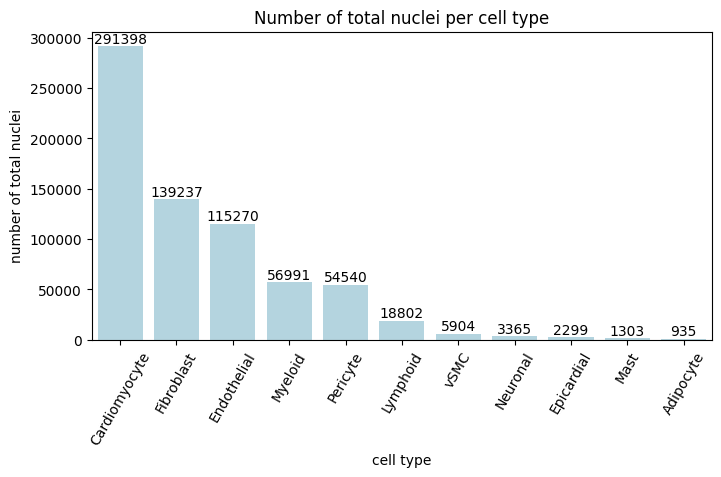

In [11]:
plt.figure(figsize=(8, 4))
sns.barplot(x='cell_type', y='n_cells', data=counts_per_cell_type, order=counts_per_cell_type['cell_type'],  color = 'lightblue')

# Add values above bars
for index, row in counts_per_cell_type.iterrows():
    plt.text(index, row.n_cells + 200, f"{row.n_cells}", ha='center', va='bottom')

plt.xlabel("cell type")
plt.xticks(rotation = 60)
plt.ylabel("number of total nuclei")
plt.title("Number of total nuclei per cell type")

plt.savefig(plots_dir + "total_snATAC_nuclei_per_cell_type.pdf")
plt.show()

### Get the number of cells per cell type and age+disease status

In [9]:
adata_metadata = peak_mat.obs

adata_metadata['combined_disease_age_status'] = ( adata_metadata['age_status'].astype(str) + "_" +
                                                 adata_metadata['disease_binary'].astype(str) )

In [10]:
cell_type_df = adata_metadata.groupby(["final_cell_type", "combined_disease_age_status"]).count().reset_index(drop = False)
cell_type_df = cell_type_df[['final_cell_type', 'combined_disease_age_status', 'age']].rename(columns = {'age': 'count'})

/mnt/data1/william/tmp/ipykernel_2757381/1405761205.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_type_df = adata_metadata.groupby(["final_cell_type", "combined_disease_age_status"]).count().reset_index(drop = False)


2025-01-20 17:15:32 - INFO - maxp pruned
2025-01-20 17:15:32 - INFO - cmap pruned
2025-01-20 17:15:32 - INFO - kern dropped
2025-01-20 17:15:32 - INFO - post pruned
2025-01-20 17:15:32 - INFO - FFTM dropped
2025-01-20 17:15:32 - INFO - GPOS pruned
2025-01-20 17:15:32 - INFO - GSUB pruned
2025-01-20 17:15:32 - INFO - glyf pruned
2025-01-20 17:15:32 - INFO - Added gid0 to subset
2025-01-20 17:15:32 - INFO - Added first four glyphs to subset
2025-01-20 17:15:32 - INFO - Closing glyph list over 'MATH': 46 glyphs before
2025-01-20 17:15:32 - INFO - Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'L', 'M', 'N', 'P', 'S', 'Y', 'a', 'b', 'c', 'd', 'e', 'eight', 'f', 'five', 'four', 'g', 'h', 'i', 'l', 'm', 'n', 'nine', 'nonmarkingreturn', 'numbersign', 'o', 'one', 'p', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'underscore', 'v', 'y', 'zero']
2025-01-20 17:15:32 - INFO - Glyph IDs:   [0, 1, 2, 3, 6, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 36, 38, 40, 41, 47, 48, 49, 51,

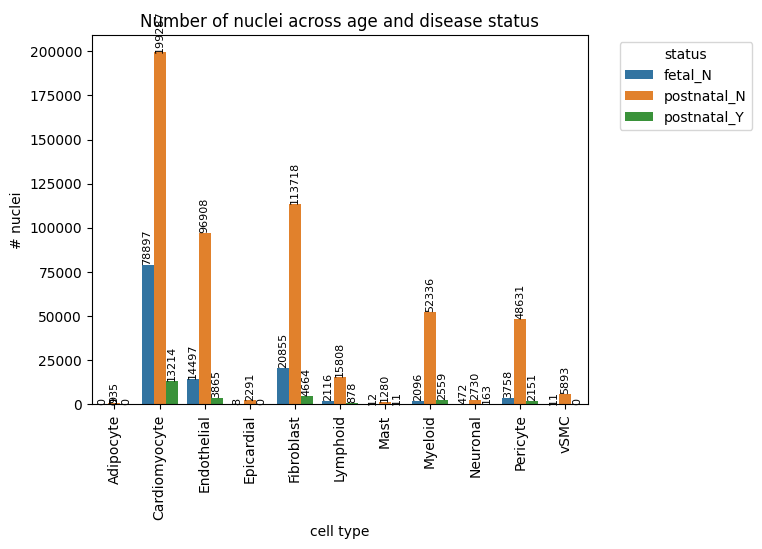

In [12]:
sns.barplot(data = cell_type_df, x = 'final_cell_type', y = 'count', hue = 'combined_disease_age_status')
plt.xticks(rotation = 90)
plt.xlabel("cell type")
plt.ylabel("# nuclei")
plt.title("Number of nuclei across age and disease status")

for p in plt.gca().patches:
    plt.text(
        p.get_x() + p.get_width() / 2,  
        p.get_height(),                 
        f'{int(p.get_height())}',      
        ha='center',                   
        va='bottom',                    
        rotation=90,                  
        fontsize=8                     
    )

plt.legend(title='status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig(plots_dir + "snATAC_n_cells_per_cell_type_disease_status.pdf")    
plt.show()